In [ ]:
#Note: training run 31-03-2022 with "new data", images with large zoom removed, species with < 10 images removed

In [1]:
from fastai.vision.all import *


/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dk_dir = Path("dk_bugs")
fin_dir = Path("finland_bugs")
ept_dir = Path("ept_bugs_preproc")
model_dir = Path(".")

In [3]:
print(len(get_image_files(dk_dir)))
print(len(get_image_files(fin_dir)))
print(len(get_image_files(ept_dir)))

2526
15074
4784


In [4]:
fin_dl = ImageDataLoaders.from_folder(path=fin_dir, valid_pct=0.2, bs=64, batch_tfms=aug_transforms(mult=1, size=224, flip_vert=True))
ept_dl = ImageDataLoaders.from_folder(path=ept_dir, valid_pct=0.2, bs=64, batch_tfms=aug_transforms(mult=1, flip_vert=True))

In [5]:
#dk_dl = ImageDataLoaders.from_folder(path=dk_dir, valid_pct=0.2, bs=32, item_tfms=Resize(224*3), batch_tfms=aug_transforms(mult=2, size=224, min_scale=0.85, flip_vert=True))
targets = [parent_label(i) for i in get_image_files(dk_dir)]
dk_dl = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items = get_image_files,
                  splitter = TrainTestSplitter(stratify=targets),
                  item_tfms=Resize(224*3), 
                  batch_tfms=aug_transforms(mult=2, size=224, min_scale=0.75, flip_vert=True),
                  get_y = parent_label).dataloaders(dk_dir, batch_size = 64)

In [6]:
dk_n = len(dk_dl.vocab)
fin_n = len(fin_dl.vocab)
ept_n = len(ept_dl.vocab)

print(dk_n)
print(fin_n)
print(ept_n)


27
64
28


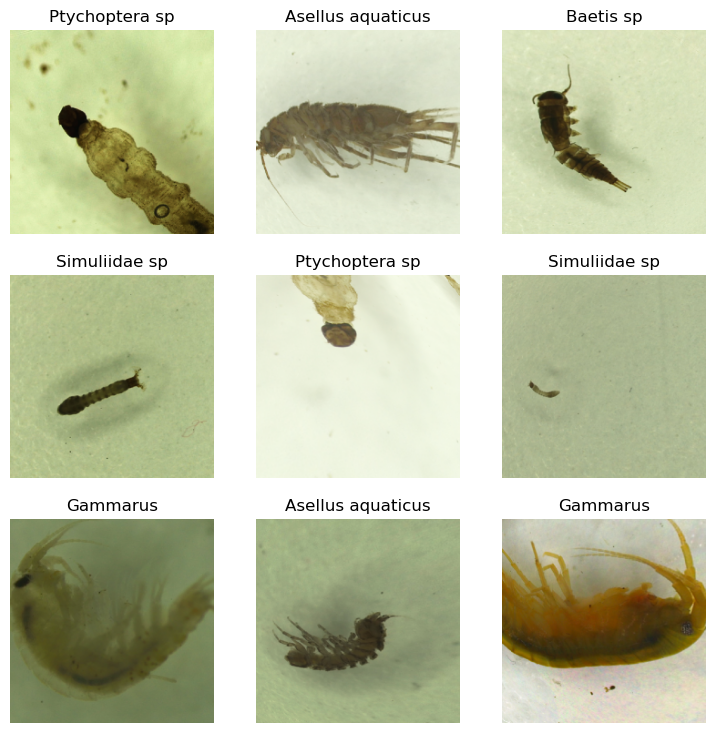

In [8]:
dk_dl.show_batch()

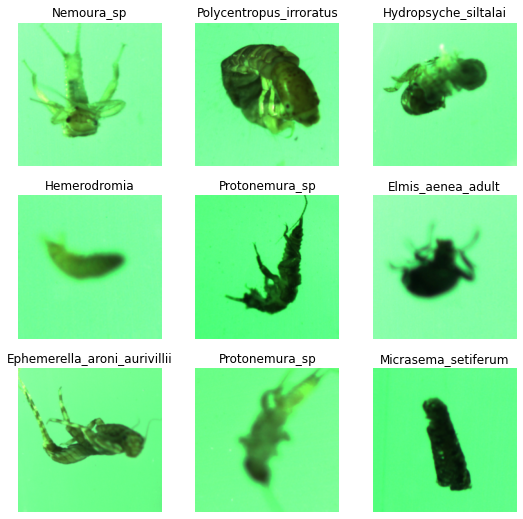

In [18]:
fin_dl.show_batch()

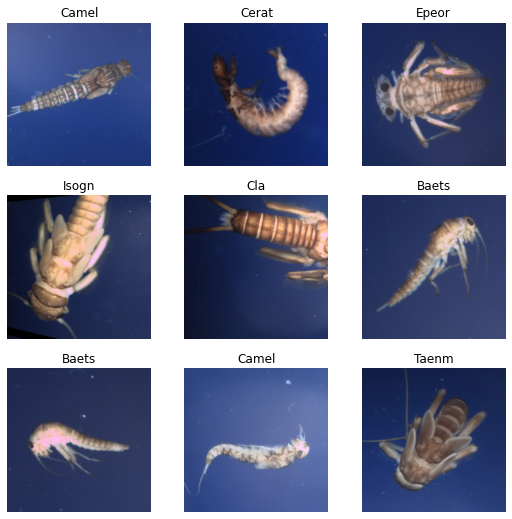

In [20]:
ept_dl.show_batch()

In [24]:
fin_learn = cnn_learner(fin_dl, resnet34, metrics=error_rate, path = model_dir)

In [25]:
fin_learn.fine_tune(10, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,3.780732,2.153201,0.555408,00:35
1,2.238812,1.395378,0.393497,00:35
2,1.737066,1.134355,0.329131,00:36


epoch,train_loss,valid_loss,error_rate,time
0,1.206798,0.809217,0.250166,00:45
1,0.942237,0.675099,0.214997,00:45
2,0.782275,0.555459,0.172860,00:45
3,0.628719,0.436550,0.145985,00:45
4,0.494326,0.362935,0.113470,00:45
5,0.389409,0.361587,0.111812,00:45
6,0.327638,0.304390,0.089914,00:46
7,0.231938,0.264074,0.073656,00:45
8,0.195659,0.242873,0.072993,00:46
9,0.174671,0.237256,0.073324,00:45


In [26]:
fin_learn.model[-1][-1]=nn.Linear(in_features=512, out_features=ept_n, bias=False)
fin_learn.save("resnet34-fin")

Path('models/resnet34-fin.pth')

In [27]:
ept_learn = cnn_learner(ept_dl, resnet34, metrics=error_rate, path = model_dir)
ept_learn.load("resnet34-fin")

In [28]:
ept_learn.fine_tune(10, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,2.603845,1.674515,0.374477,00:11
1,1.329393,0.640601,0.174686,00:11
2,0.712907,0.408668,0.128661,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.296940,0.284190,0.085774,00:14
1,0.208208,0.219517,0.064854,00:15
2,0.150904,0.216242,0.064854,00:14
3,0.126593,0.182661,0.065900,00:14
4,0.092242,0.153999,0.052301,00:14
5,0.069626,0.137605,0.040795,00:14
6,0.045006,0.127627,0.038703,00:14
7,0.034313,0.106080,0.034519,00:14
8,0.026002,0.096202,0.029289,00:14
9,0.023125,0.100267,0.030335,00:14


In [29]:
ept_learn.model[-1][-1]=nn.Linear(in_features=512, out_features=dk_n, bias=False)
ept_learn.save("resnet34-fin-ept")

Path('models/resnet34-fin-ept.pth')

In [51]:
dk_learn = cnn_learner(dk_dl, resnet34, metrics=error_rate, path = model_dir, loss_func=LabelSmoothingCrossEntropy(), cbs=MixUp())  #
dk_learn.load("resnet34-fin-ept")

In [52]:
dk_learn.fine_tune(25, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,3.126774,1.965385,0.308300,00:16
1,2.390985,1.071809,0.140316,00:15
2,1.996578,0.960156,0.110672,00:16


epoch,train_loss,valid_loss,error_rate,time
0,1.531384,0.904181,0.088933,00:17
1,1.494800,0.870737,0.079051,00:17
2,1.462028,0.820605,0.051383,00:17
3,1.424186,0.794188,0.041502,00:17
4,1.387657,0.795676,0.039526,00:17
5,1.347013,0.786912,0.031621,00:17
6,1.316983,0.796323,0.045455,00:17
7,1.286819,0.761357,0.033597,00:17
8,1.269659,0.760338,0.021739,00:17
9,1.247656,0.769444,0.025692,00:17


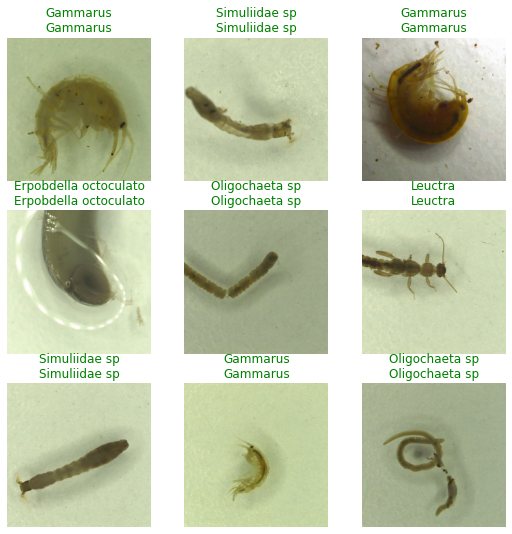

In [53]:
dk_learn.show_results()


In [54]:
dk_learn.export(Path("models")/"resnet34-fin-ept-dk.export")

In [55]:
preds, y, losses = dk_learn.get_preds(with_loss=True)
interp = ClassificationInterpretation.from_learner(dk_learn)

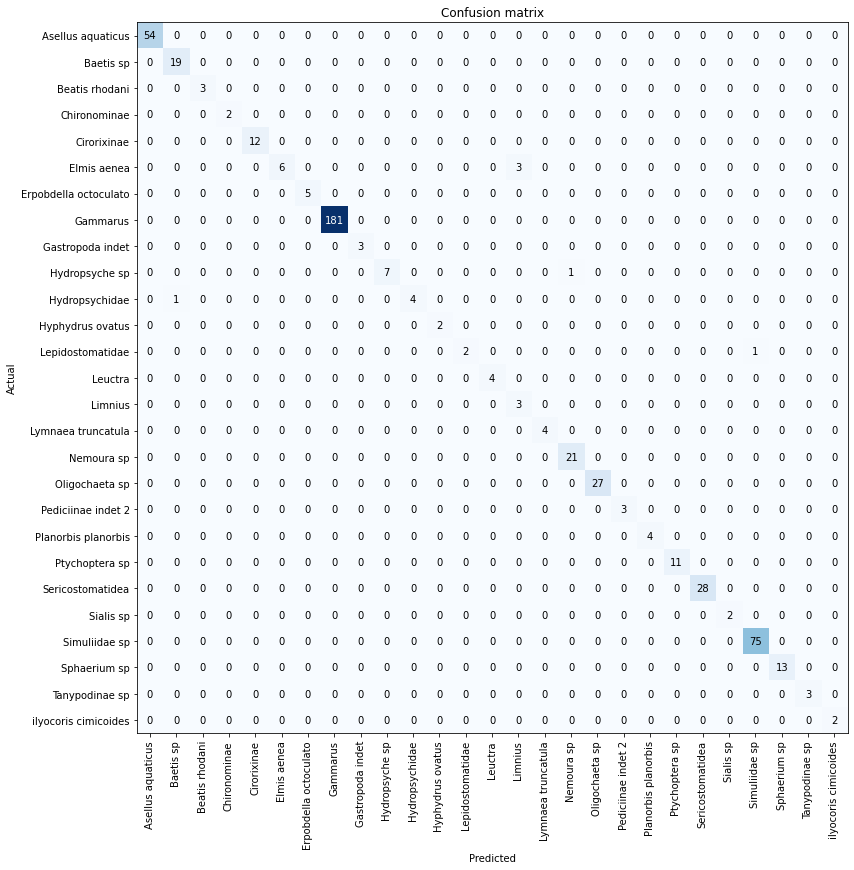

In [56]:
interp.plot_confusion_matrix(figsize=(12,12))
